# notes on spectral decomposition

These are my notes on spectral decomposition. 

What I show here is mainly how to reproduce some of the figures in "Interpretational applications of spectral decomposition in reservoir characterization" (Partyka et al., The Leading Edge, March 1999). I think these are very instructive, and trying to reproduce them from scratch has really helped me in understanding all these frequency stuff.

In my last update (July 2015), I have also included code to build peak frequency vs thickness plots, which have been featured on a few papers in recent years (e.g., Chen et al., 2008, and Deng et al., 2007).

## libraries required

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import agilegeo
import segypy
import aaplot
import aawedge
%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

Apart from the usual Numpy and Matplotlib, you also need the _agilegeo_ library (to install it, use `pip install agilegeo`), _segypy_, _aaplot_ and _aawedge_; these last three are all available for download from my repo:  <https://github.com/aadm/geophysical_notes>.

_aaplot_ and _aawedge_ contain code to build wedges and do some custom plotting; they are explained and discussed in this other notebook: [wedge_modeling](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/wedge_modeling.ipynb).


## creating a wedge

The following code will build a wedge with elastic properties which are the typical class 3 AVO gas sand discussed in Hilterman, 2001 ("Seismic Amplitude Interpretation", SEG-EAGE DISC course).

A few plots are created to check the initial earth model, the final synthetic seismic wedge and the wavelet used.

The wedge can be saved as a Numpy array with:

    np.save('wedge_class3',sint)
    
Or as a standard SEG-Y with:

    segypy.write_segy('wedge_class3.sgy',sint)

wedge minimum thickness: 1.00 m
wedge maximum thickness: 35.00 m
wedge vertical sampling: 0.10 m
wedge samples, traces: 1350x100


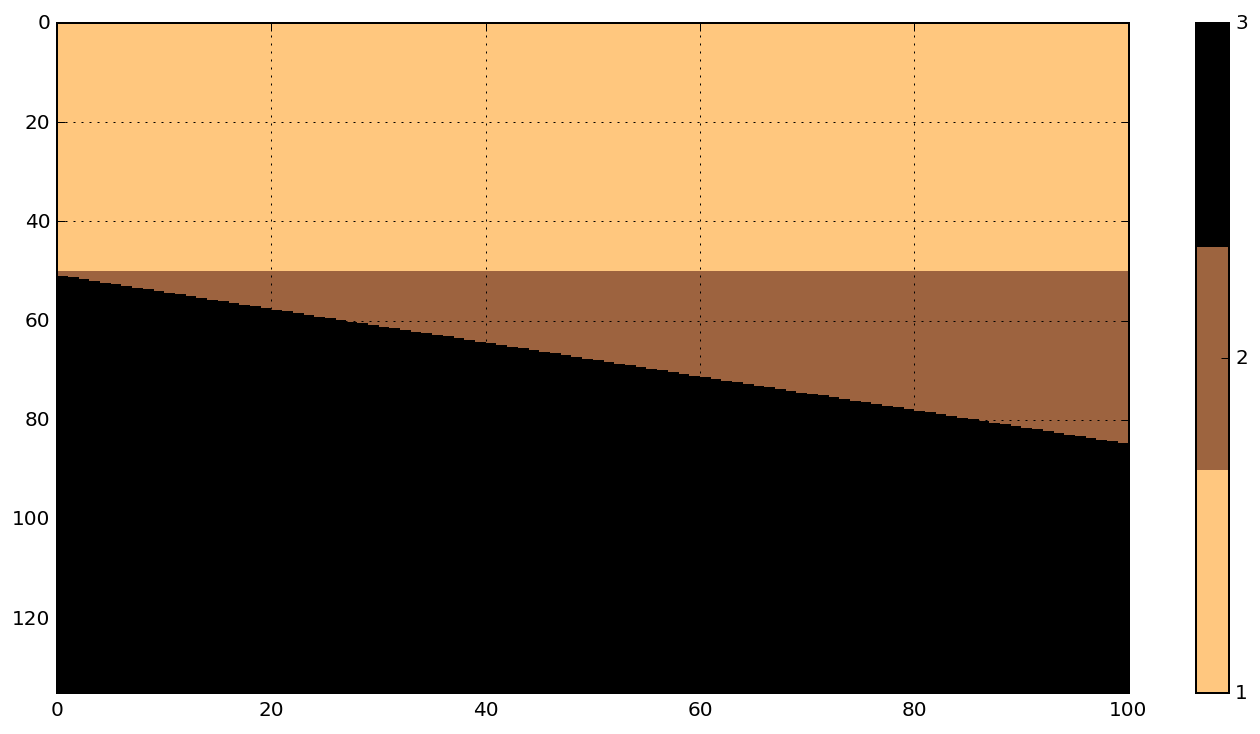

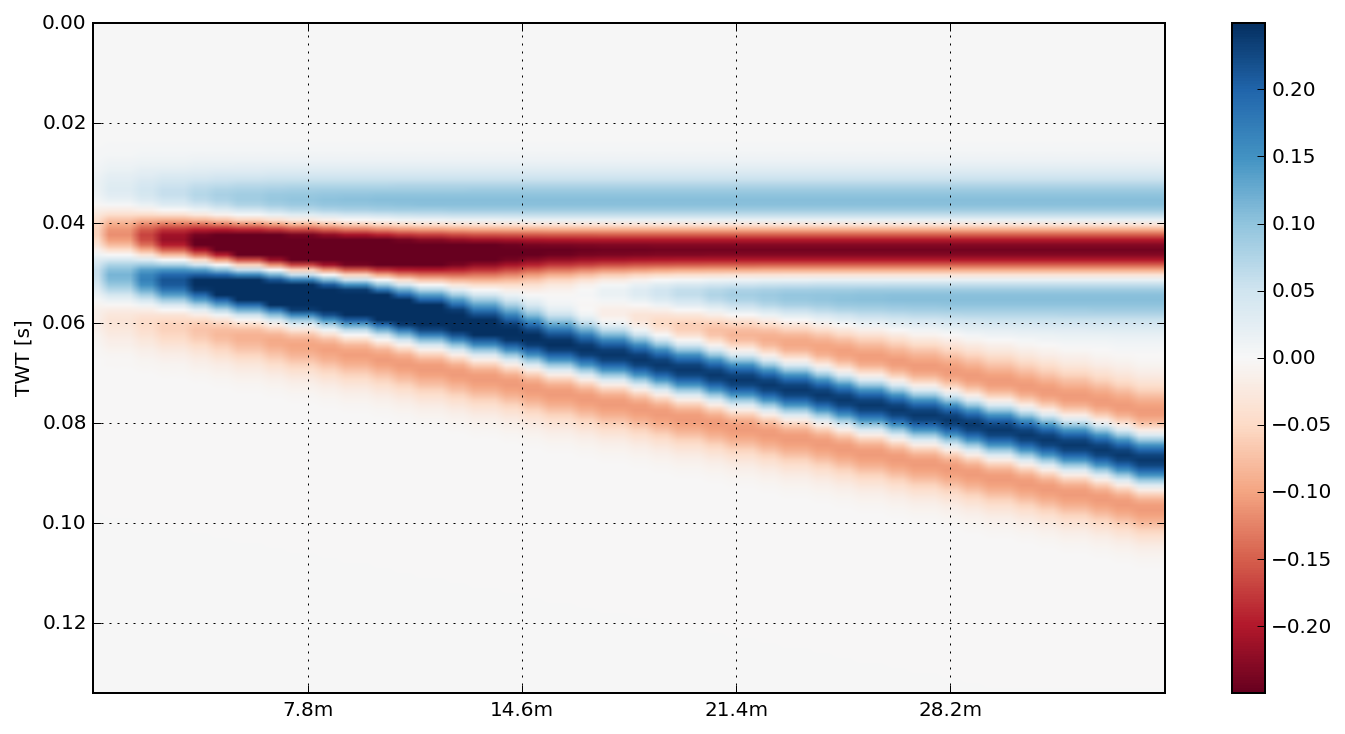

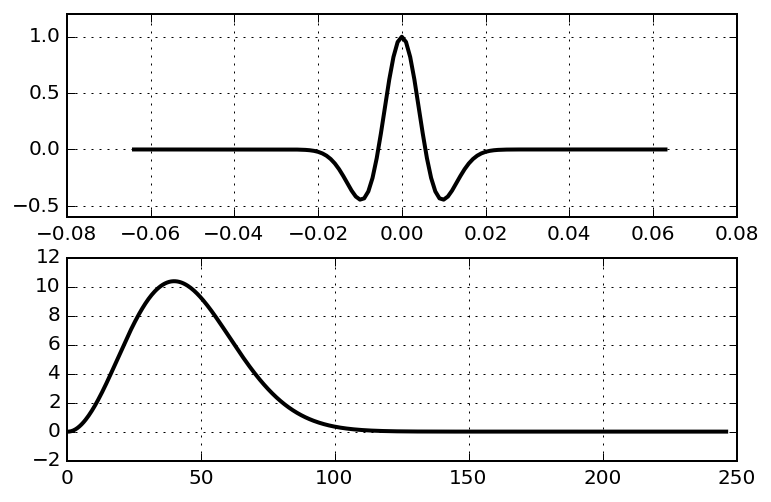

In [27]:
freq=40
srz=0.1   # 1 vertical sample in depth domain = 0.1 m
srt=0.001 # 1 vertical sample in time domain = 0.001 s = 1 ms
min_thickness=1
max_thickness=35
encasing=50
n_traces=100
duration=0.128

acprop=np.array([[2191,2.16,818],[1542,1.88,901],[2191,2.16,818]])

wavl=agilegeo.wavelet.ricker(duration, srt, freq)
wedge=aawedge.make_wedge(n_traces=n_traces,encasing_thickness=encasing,min_thickness=min_thickness,max_thickness=max_thickness,dz=srz)
sint=aawedge.forward_model(model=wedge,aiprop=acprop,wavelet=wavl,dz=srz,dt=srt)

# plot rock grid
aaplot.plot_rock_grid(wedge,srz)

# plot wedge
aaplot.plot_density(sint,srt), plt.ylabel('TWT [s]')
aaplot.update_xlabels(min_thickness,max_thickness,n_traces)

# plot wavelet & spectrum
time=np.arange(-duration/2, duration/2 , srt)
aaplot.plot_wavelet_spectrum(wavl,time,srt)

## spectral decomposition

This code will run do spectral decomposition on our wedge; the frequencies that the data will be sliced in are 10, 20, 30, 40 Hz; the window length will be 20 ms. The algorithm is a STFT (Short Time Fourier Transform), exactly the same one that [OpenDTect](http://opendtect.org/rel/doc/User/base/appendix_spectral-decomposition.htm) uses.

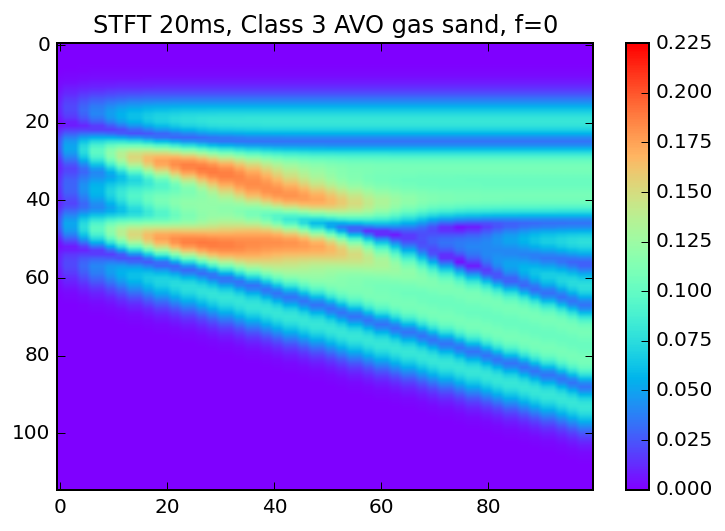

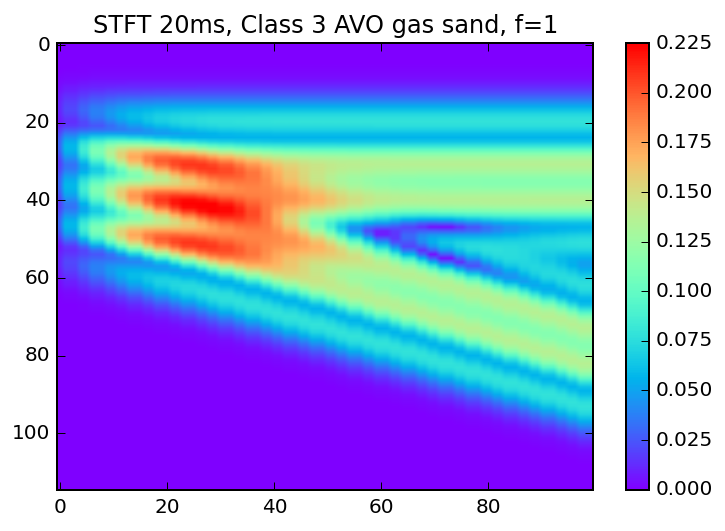

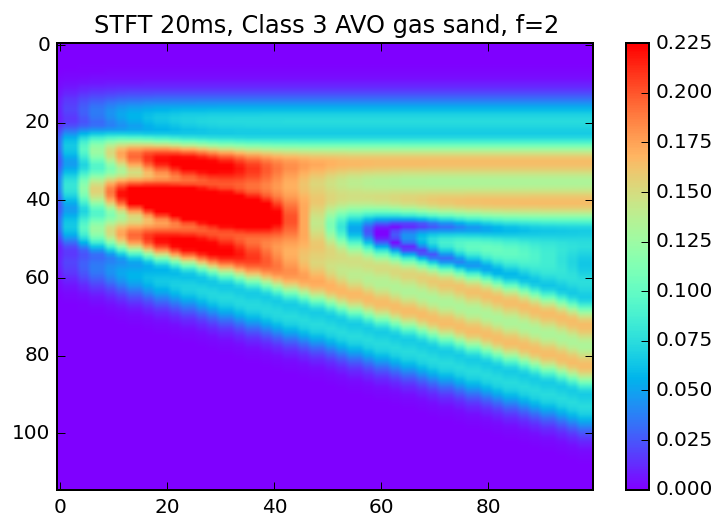

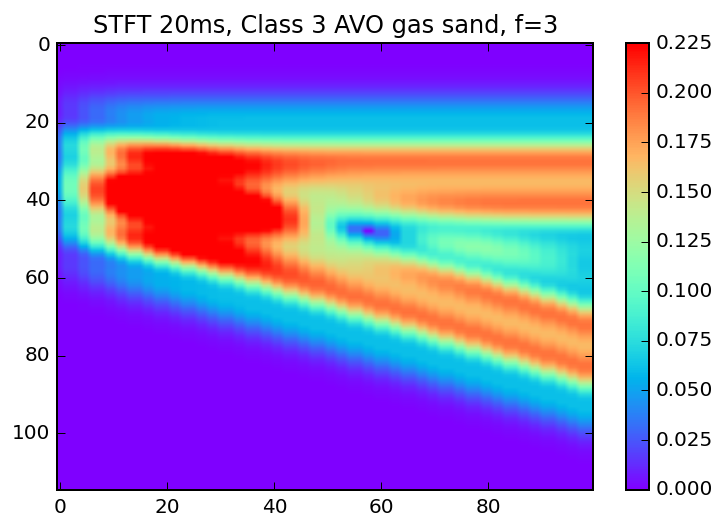

In [28]:
sd=agilegeo.attribute.spectraldecomp(sint, f=(10,20,30,40),\
                                     window_length=0.020,\
                                     dt=srt,window_type='boxcar')
for i in range(sd.shape[2]):
    plt.figure()
    plt.imshow(sd[:,:,i],aspect='auto',interpolation='bilinear',cmap='rainbow')
    plt.clim(0,.225)
    plt.title('STFT 20ms, Class 3 AVO gas sand, f='+str(i)), plt.colorbar()

## thickness and notches in spectra

Now I will investigate the relation between thickness and notches in the amplitude spectrum. This is discussed in Partyka's paper (p.354).

This first bit of code will simply extract 3 traces from our wedge corresponding to the chosen thicknesses; remember that the wedge was originally defined with the following geometry:

In [11]:
print min_thickness
print max_thickness

1
35


so if you change the following array use thicknesses that fall in this range.

In [12]:
thickness=np.array([5,15,25])

[ns,nt]=sint.shape
twt=np.arange(0,ns*srt,srt)

incr=(max_thickness-min_thickness)/float(nt)
thickness_traces=np.floor(thickness/incr)
tt=np.zeros((sint.shape[0],thickness.size))
for i,val in enumerate(thickness_traces):
    tt[:,i]=sint[:,val]

Then I will plot again the wedge highlighting the traces corresponding to `thickness`:

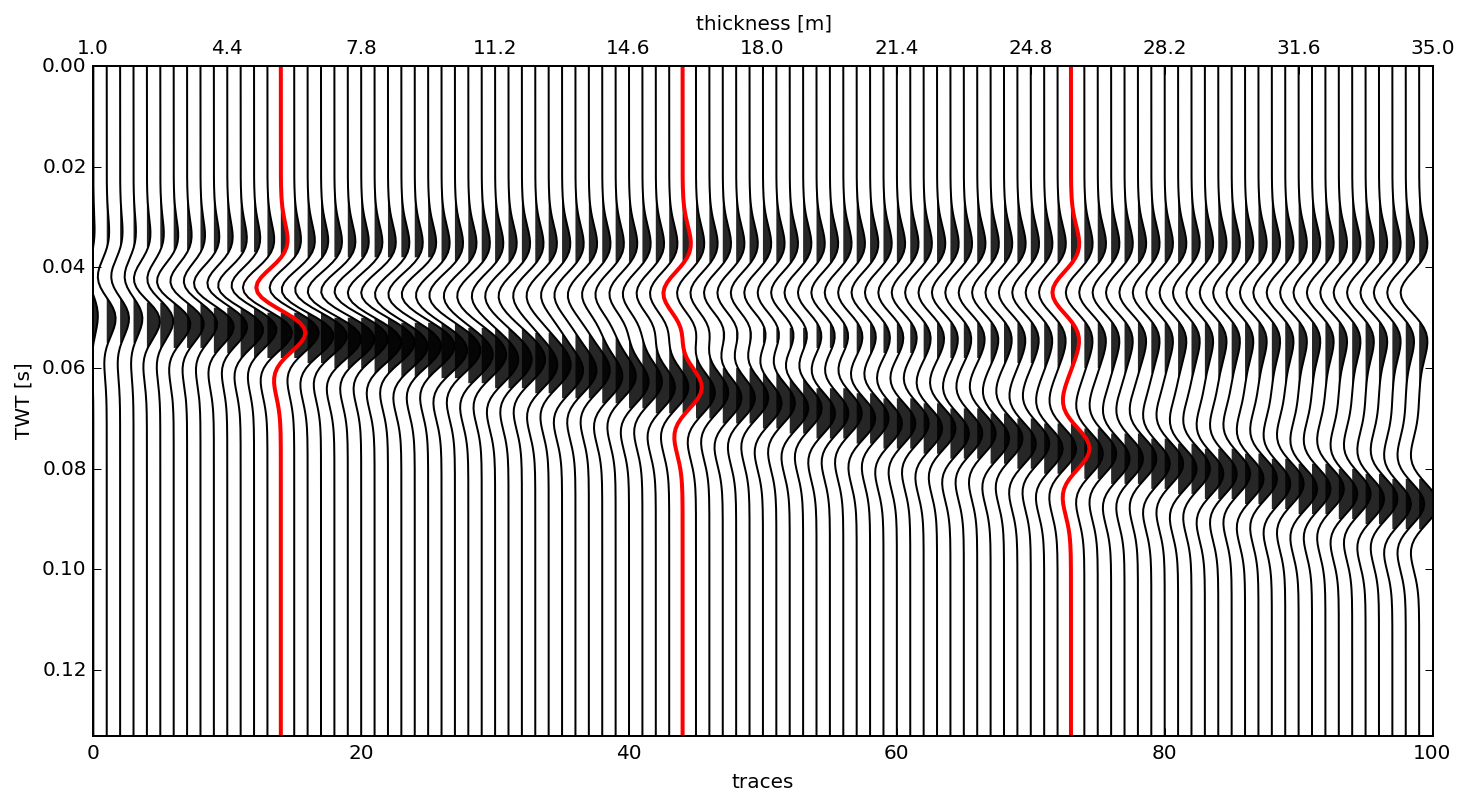

In [30]:
# wiggle plot della sismica con evidenziate in rosso le tracce scelte
fig, ax1 = plt.subplots(figsize=(12,6))
# plt.figure(figsize=(12,6))
for i in range(0,nt):
    trace=sint[:,i]/np.max(np.abs(sint))*2
    if i in thickness_traces:
        ax1.plot(i+trace,twt,color='r',lw=2)
    else:
        ax1.plot(i+trace,twt,color='k')
    ax1.fill_betweenx(twt,trace+i,i,where=trace+i>i,facecolor='k',lw=0,alpha=0.85)
ax1.set_xlim(0,nt)
ax1.set_ylim(min(twt),max(twt))
ax1.invert_yaxis()
ax1.set_xlabel('traces')
ax1.set_ylabel('TWT [s]')
ax2 = ax1.twiny()
ax2.set_xticks(range(0,nt+1,10))
ax2.set_xticklabels(np.arange(0,nt+1,10)*incr+min_thickness)
ax2.set_xlabel('thickness [m]')

Finally, I will plot again the same three traces with their amplitude spectra below:

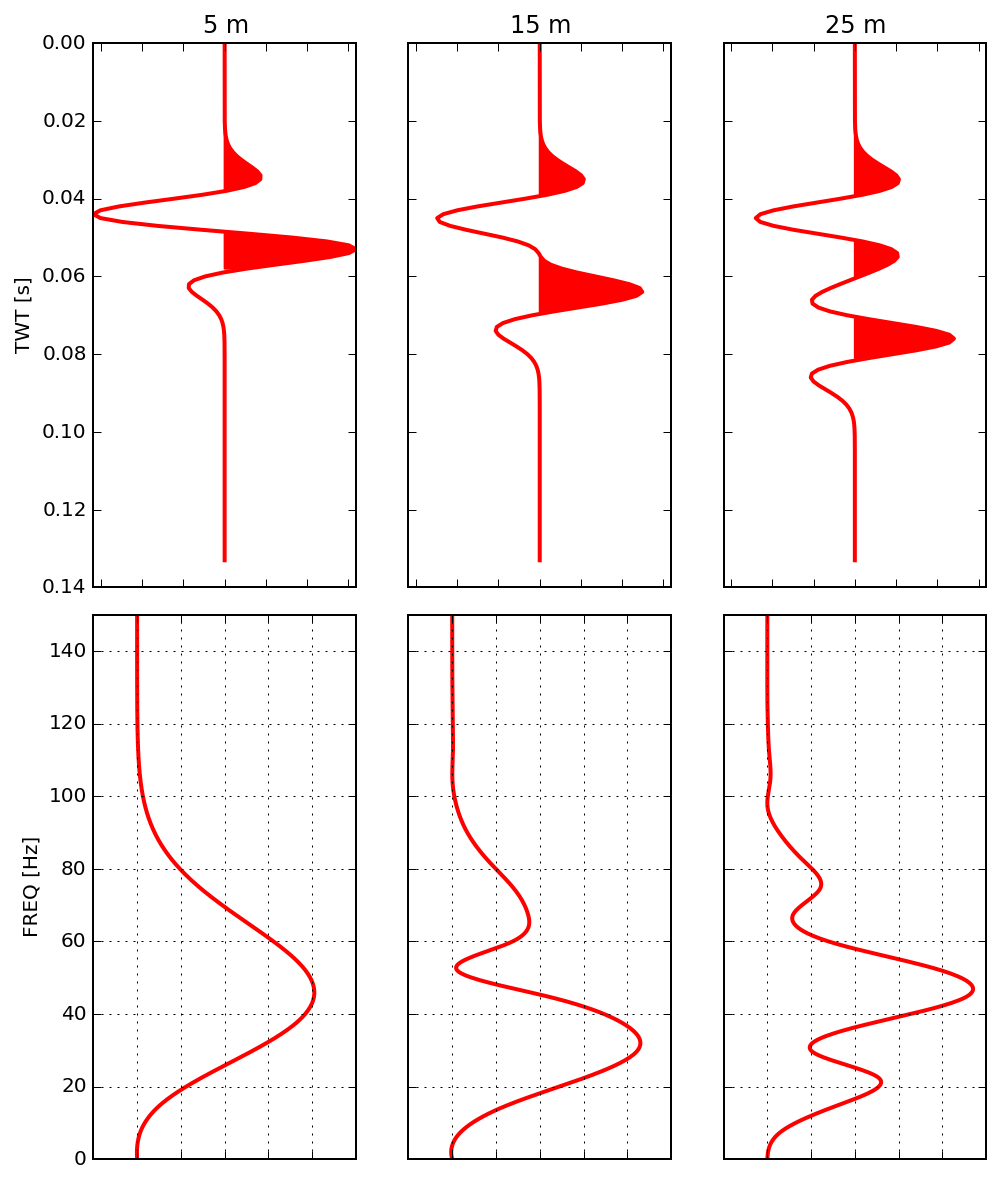

In [31]:
f, ax = plt.subplots(nrows=2,ncols=3,figsize=(8,10))
for i in range(0,3):
    ufft,ufreq=aaplot.ampspec(tt[:,i],srt)
    ax[0,i].plot(tt[:,i],twt,color='r',lw=2)
    ax[0,i].fill_betweenx(twt,tt[:,i],0,tt[:,i]>0.0, color='r')
    ax[1,i].plot(ufft,ufreq,color='r',lw=2)
    ax[0,i].set_title('%d m' % thickness[i])
    # riga in alto
    ax[0,i].set_xlim(np.min(tt),np.max(tt))
    plt.setp(ax[0,i].get_xticklabels(), visible=False)
    plt.setp(ax[0,i].get_yticklabels(), visible=False)
    # riga in basso
    ax[1,i].set_ylim(150,0)
    # ax[1,i].set_xlim(-0.1,1.1)
    plt.setp(ax[1,i].get_xticklabels(), visible=False)
    plt.setp(ax[1,i].get_yticklabels(), visible=False)
    ax[1,i].grid()
ax[0,0].set_ylabel('TWT [s]')
ax[1,0].set_ylabel('FREQ [Hz]')
plt.setp(ax[0,0].get_yticklabels(), visible=True)
plt.setp(ax[1,0].get_yticklabels(), visible=True)
for aa in ax.flatten():
    aa.invert_yaxis()
f.subplots_adjust(hspace=0.05)

The plot above demostrates the relation between notches in the spectrum and thickness, as Partyka wrote:

> [...] The temporal thickness of the wedge determines the period of the notches in the amplitude spectrum with respect fo frequency. Pf = 1/t where Pf=period of notches [...] and t=thin bed thickness.

With a little bit of extra code we can demonstrate this taking into account the thirdmost trace, i.e. the one that has more notches.

_NOTE: Partyka specifically mentions that we should really use a short-time window Fourier transform also for these spectra, but I have seen that the thing still works even using a normal FFT. Please help/comment on this!_

In [17]:
nn=2 # selects the third thickness
ufft,ufreq=aaplot.ampspec(tt[:,nn],srt)
from scipy.signal import argrelextrema
mins=ufreq[argrelextrema(ufft, np.less)]

print 'TO MEASURE THICKNESS FROM AMPLITUDE SPECTRA:'
print 'trace number %d, corresponding to a wedge thickness of %d m' % (nn, thickness[nn])
print 'minima of amplitude spectra are at:'
for uu in mins[mins<150]: print '%5.1f Hz' % uu
print 'interval between notches in Hz is:'
for uu in np.diff(mins[mins<150]): print '%5.1f Hz' %  uu
print 'average value is  %.2f Hz' % np.mean(np.diff(mins[mins<150]))
print 'which corresponds to a %.4f s interval\n' % (1/np.mean(np.diff(mins[mins<150])))
print 'NOW TO CROSS-CHECK THIS RESULT CONSIDER THAT:'
print 'a %d m thickness, considering an average velocity of %d m/s' % (thickness[nn], acprop[1,0])
print 'is equivalent to twt = 2*z/vel = %.4f s' % ((2*thickness[nn])/acprop[1,0])

TO MEASURE THICKNESS FROM AMPLITUDE SPECTRA:
trace number 2, corresponding to a wedge thickness of 25 m
minima of amplitude spectra are at:
 30.9 Hz
 66.3 Hz
 98.3 Hz
129.9 Hz
interval between notches in Hz is:
 35.3 Hz
 32.0 Hz
 31.7 Hz
average value is  33.01 Hz
which corresponds to a 0.0303 s interval

NOW TO CROSS-CHECK THIS RESULT CONSIDER THAT:
a 25 m thickness, considering an average velocity of 1542 m/s
is equivalent to twt = 2*z/vel = 0.0324 s


## figures 4 and 5

My version of figure 4 of Partyka et al's paper:

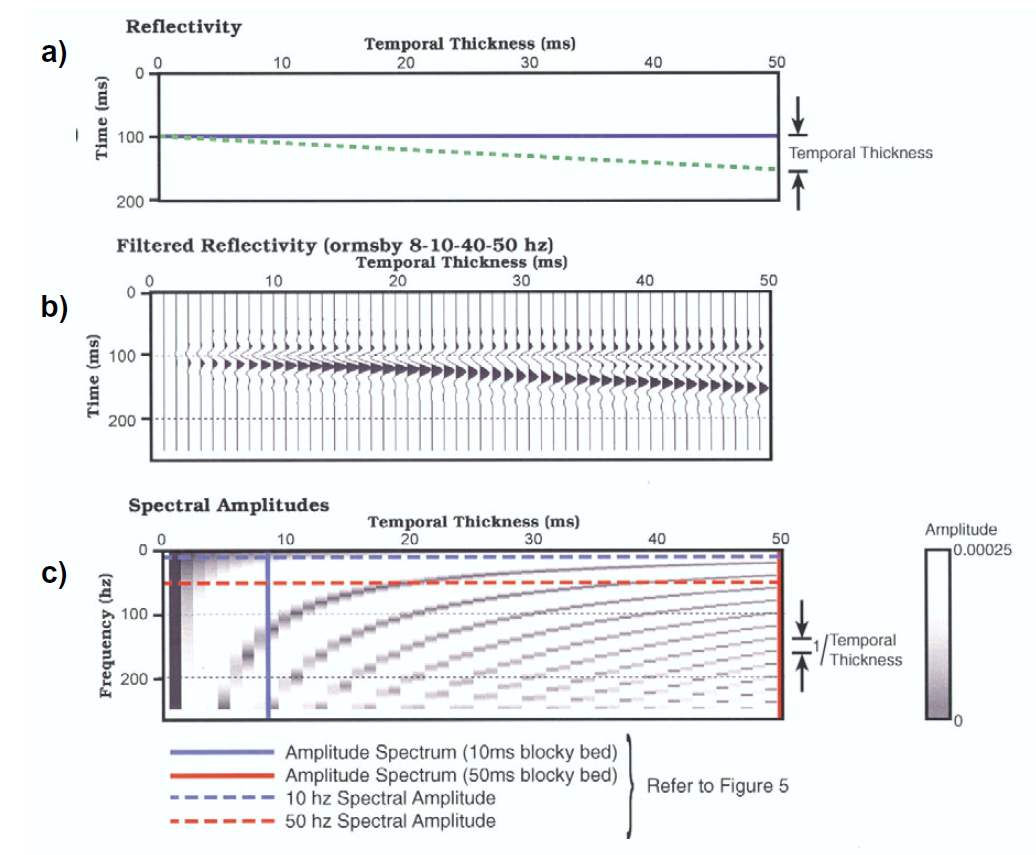

In [32]:
from IPython.display import Image
Image(filename='Partyka_1999_fig4.png')

This is again a way to demonstrate the same concepts, i.e. relation between notches (white in my figure below) in the spectra of the individual traces and their thickness. What I show below is the input wedge and a _spectral amplitude section_ (not sure this is the "correct" name or even if Partyka bothered with naming this thing).

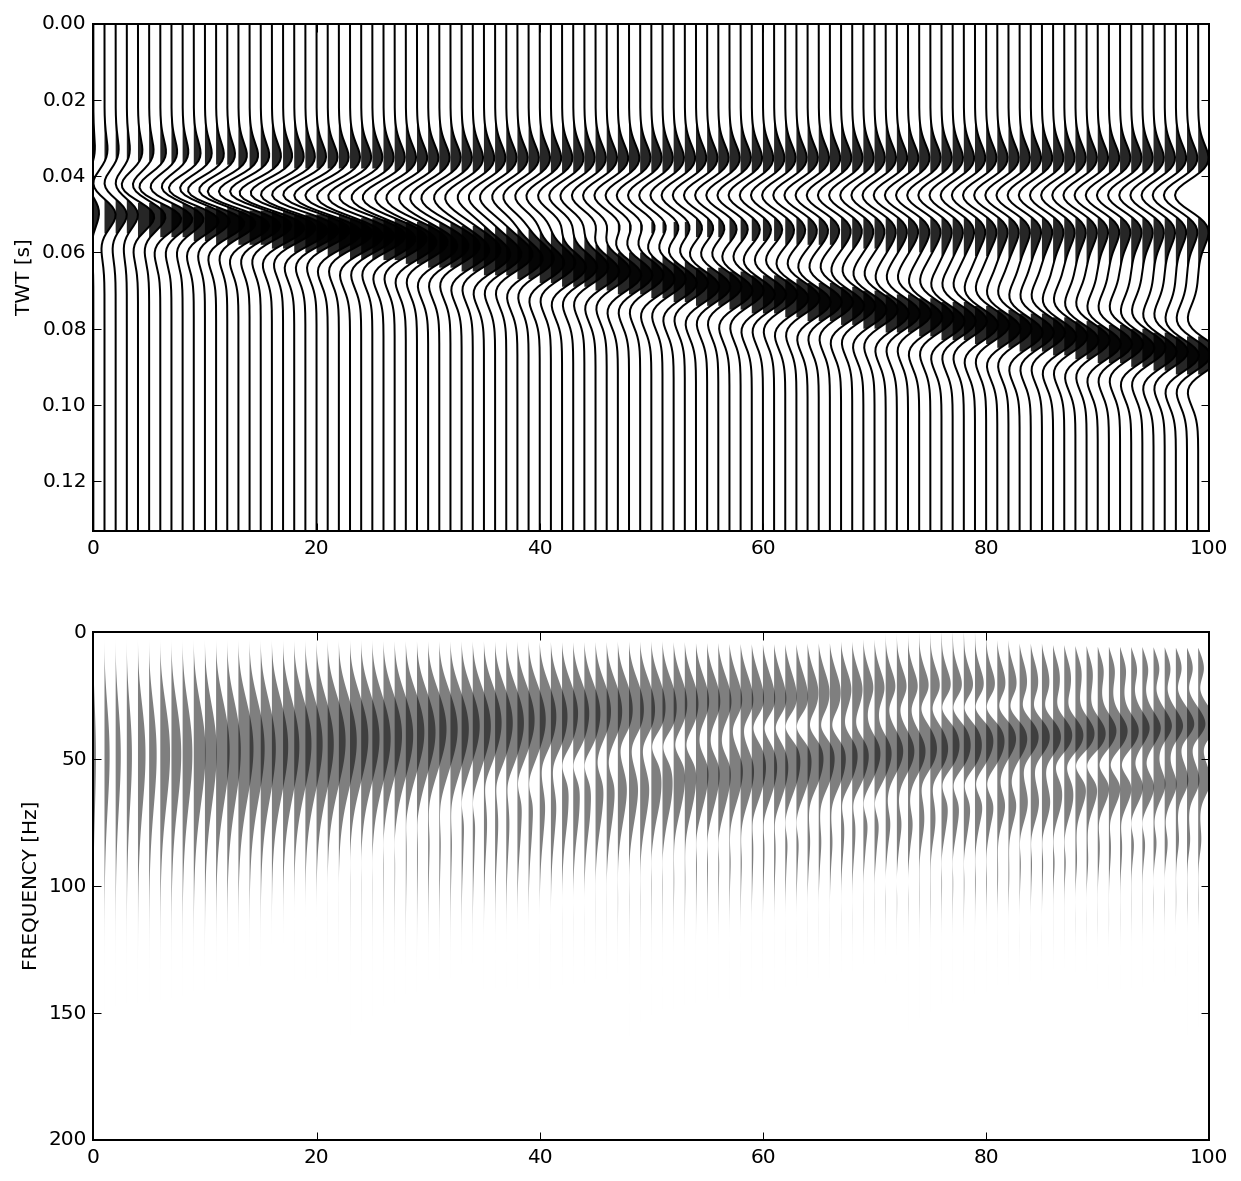

In [38]:
gain=3 # parameters to adjust the wiggle display
skip=1

[ns,nt]=sint.shape
twt=np.arange(0,ns*srt,srt)

amp0,ff0=aaplot.ampspec(sint[:,0],srt)
spectra=np.zeros((amp0.size,nt))
for i in range(nt):
    amp,ff=aaplot.ampspec(sint[:,i],srt)
    spectra[:,i]=amp

f, ax = plt.subplots(2,figsize=(10,10))
for i in range(0,nt,skip):
    trace=sint[:,i]/np.max(np.abs(sint))*gain
    spect=spectra[:,i]/gain
    ax[0].plot(i+trace,twt,color='k')
    ax[0].fill_betweenx(twt,i+trace,i,where=i+trace>i,facecolor='k',lw=0,alpha=0.85)
    ax[1].fill_betweenx(ff,i+spect,i,where=i+spect>i,facecolor='k',lw=0,alpha=0.5)
for aa in ax.flatten():
    aa.set_xlim(0,nt)
ax[0].set_ylim(max(twt),min(twt))
ax[0].set_ylabel('TWT [s]')
ax[1].set_ylim(200,0)
ax[1].set_ylabel('FREQUENCY [Hz]')

The same display as density plot, just for fun (and uses less lines of code):

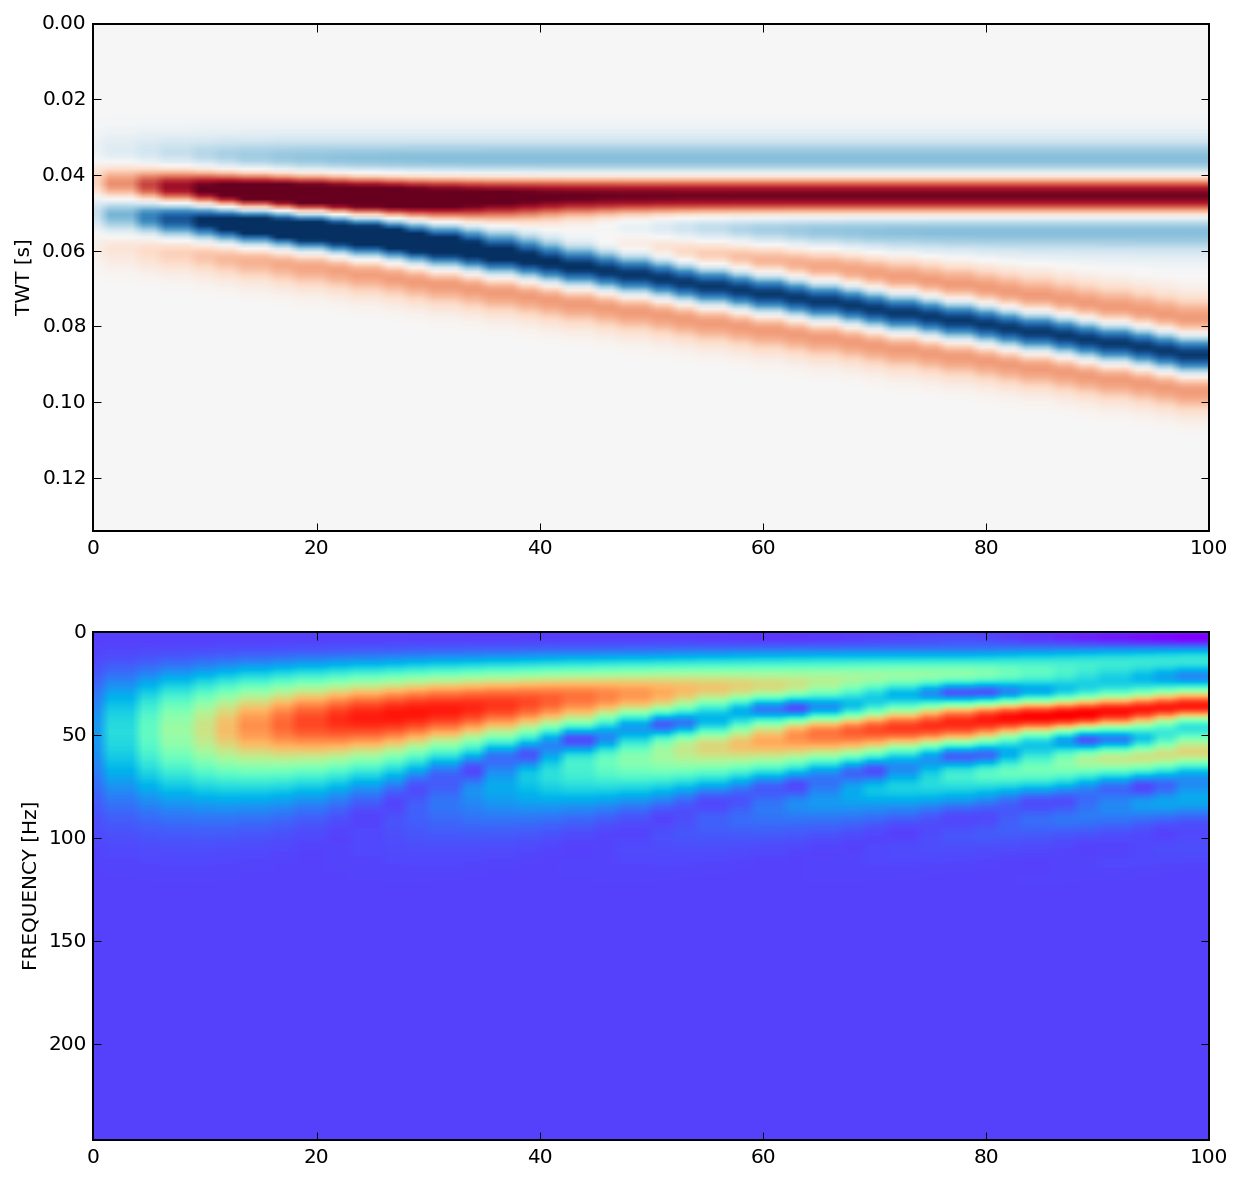

In [40]:
# fig.4, color density display
clip=abs(np.percentile(sint, 0.999))
f, ax = plt.subplots(2,figsize=(10,10))
im0=ax[0].imshow(sint,extent=[0,sint.shape[1],sint.shape[0]*srt,0],interpolation='bilinear',aspect='auto',cmap='RdBu',vmin=-clip,vmax=clip)
im1=ax[1].imshow(spectra,extent=[0,spectra.shape[1],ff.max(),0],interpolation='bilinear',aspect='auto',cmap='rainbow')
ax[0].set_ylabel('TWT [s]')
ax[1].set_ylabel('FREQUENCY [Hz]')

The following plot is another way to display the same concept of thin-bed tuning versus frequency (p.356 of Partyka et al.'s paper; this is sort of my reinterpretation of figure 5, i.e. how I understood what was going on in that figure).

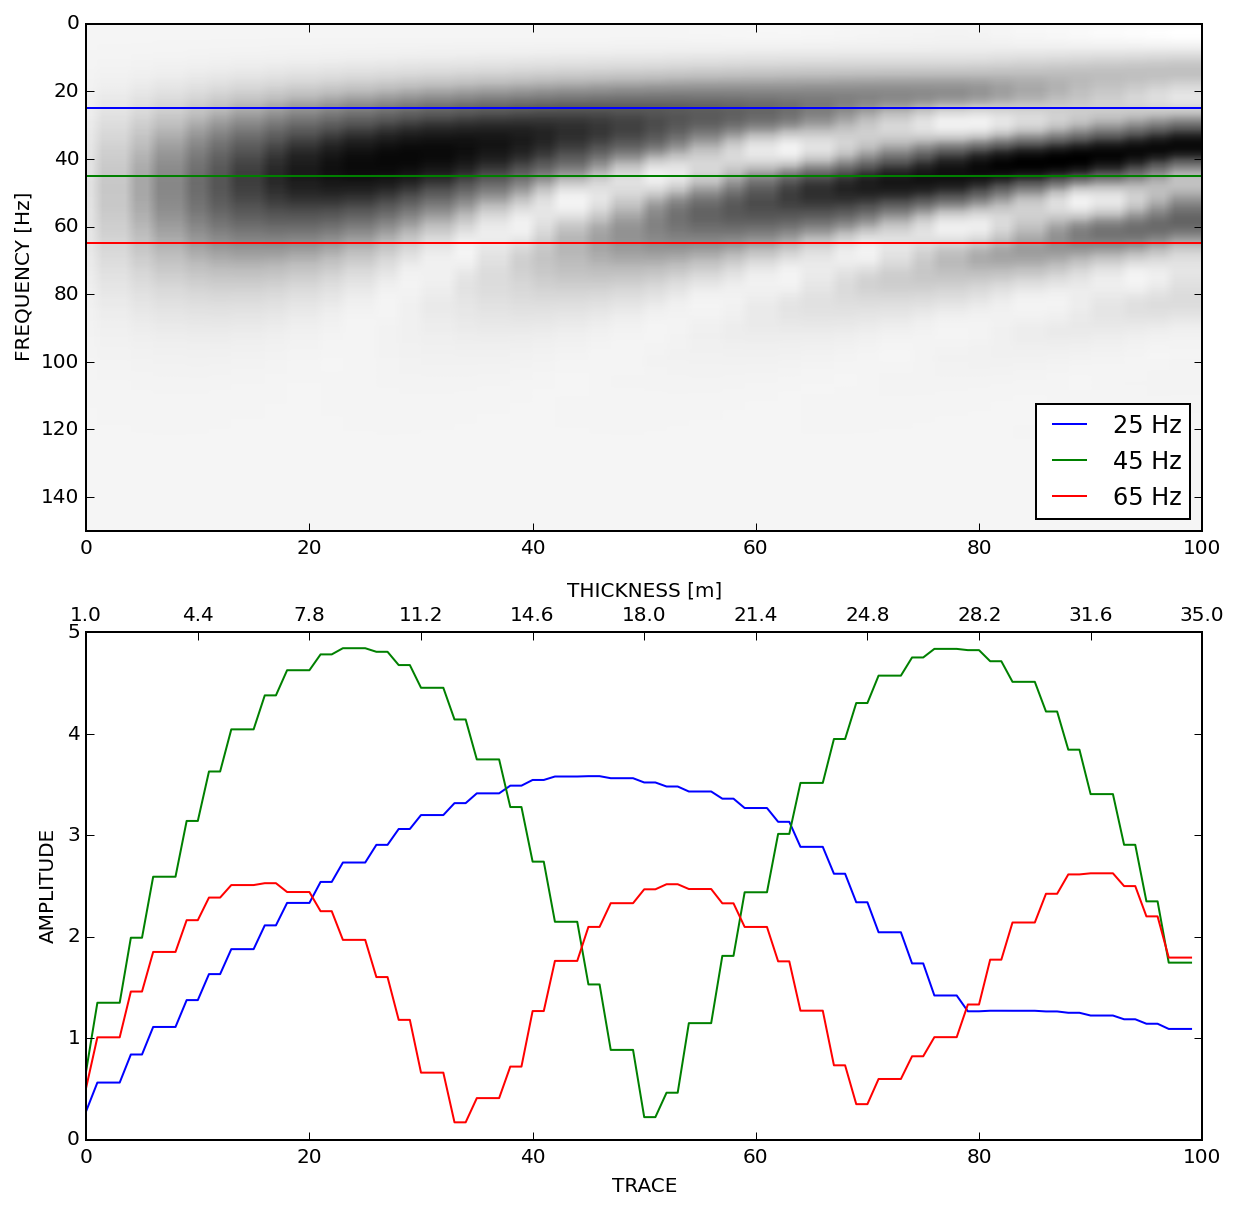

In [62]:
uu=[25,45,65]


f, ax = plt.subplots(2,figsize=(10,10))
ax[0].imshow(spectra,extent=[0,spectra.shape[1],ff.max(),0],interpolation='bilinear',aspect='auto',cmap='Greys')
for u in uu:
    ax[0].plot([0,spectra.shape[1]],[u,u],label=str(u)+' Hz')
    ind=(np.abs(ff-u)).argmin()
    ax[1].plot(spectra[ind,:])
ax[0].set_ylim(150,0)
ax[0].set_ylabel('FREQUENCY [Hz]')
ax[0].legend(loc='lower right')
ax[1].set_ylabel('AMPLITUDE')
ax[1].set_xlabel('TRACE')
ax2 = ax[1].twiny()
ax2.set_xticks(range(0,nt+1,10))
ax2.set_xticklabels(np.arange(0,nt+1,10)*incr+min_thickness)
ax2.set_xlabel('THICKNESS [m]')

If we slice this spectral amplitudes section at constant frequencies (in this example 25, 45 and 65 Hz) we see again a ciclicity.

What we saw before, in taking the individual spectra of each trace and looking at the notch spacing, was the relation:

\\[ P_f = 1/t \\]

In here we see the reverse, i.e.:

\\[ P_t = 1/f \\]

which is, the period in the spectra notches is equivalent to the thickness in ms. 

For example, the green curve above (45 Hz) shows a period of approximately  18 m, and using as interval velocity the same we have defined at the beginning when building the wedge (see `acprop` definition at the top of the notebook) we obtain a corresponding two-way-time thickness of:

In [66]:
twt=18./1542.*2
print 'twt thickness equivalent in ms: %.4f' % twt

twt thickness equivalent in ms: 0.0233


by simply using the relation above we would have had (almost) the same result:

In [67]:
twt_using_Pt=1/45.
print 'twt thickness equivalent in ms: %.4f' % twt_using_Pt

twt thickness equivalent in ms: 0.0222


This means that high frequencies 'see' small thicknesses and vice-versa:

* 25 Hz lets you see a bed 40 ms-thick
* 45 Hz: 22 ms
* 65 Hz: 15 ms!
* etc.

## peak frequency plots

Currently under testing...

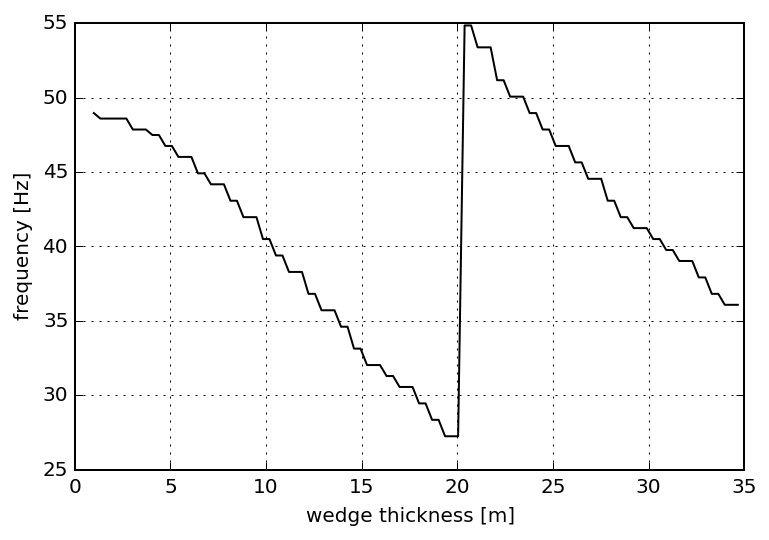

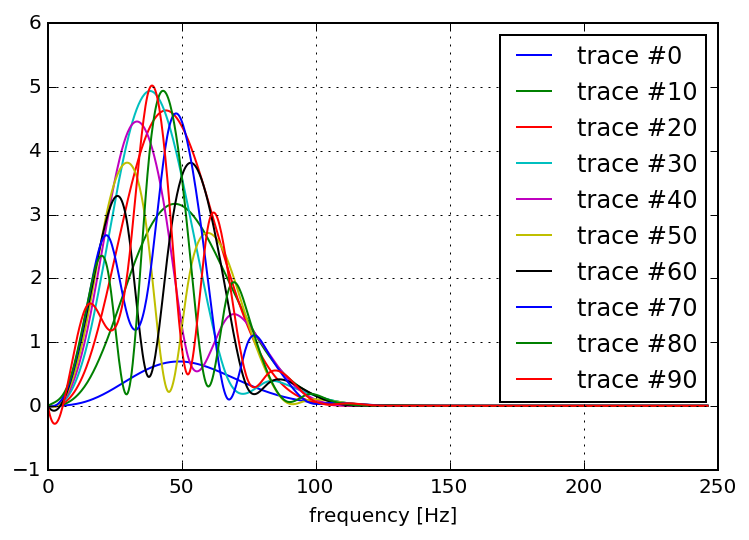

In [69]:
aft,spectra=aawedge.extract_peakfreqs(sint,min_thickness,max_thickness,srt)

plt.figure()
plt.plot(aft[2,:],aft[1,:],'-k')
plt.xlabel('wedge thickness [m]')
plt.ylabel('frequency [Hz]')
plt.grid()

plt.figure()
for i in range(0,spectra.shape[1],10):
   plt.plot(ff,spectra[:,i],label='trace #%d' % i)
plt.xlabel('frequency [Hz]')
plt.grid()
plt.legend()